In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

from scipy.stats import ortho_group
from scipy.sparse import random

from scipy.sparse import csr_matrix

# Problem statement

Given $A\in \mathbb{R}^{n\times d}, b\in \mathbb{R}^{n}$ find
$$
    arg\min_{x\in \mathbb{R}^{d}, \|x\|_{1}\leq 1}\frac{1}{2}\|Ax - b\|_{2}^{2}
$$
as fast and as accurate as possible.

#Auxilary functions

1. `projection(v, R)` - computes projection of v onto the $B_S$ ball
2. `LMO(g)` (`LMO_sparse` for sparse vector) - computes
$$
    arg\min_{z\in \mathbb{R}^{d}, \|z\|_{1}= 1}\langle g,   z \rangle
$$
3. `construct_random_matrix(n: int, m: int, cond_number: float)` - construct random $n \times m$ matrix with condition number $cond_{number}$

In [2]:
def projection_simplex(v, s=1):
    n, = v.shape  
    if v.sum() == s and np.alltrue(v >= 0):
        return v
    u = np.sort(v)[::-1]
    cumsum = np.cumsum(u)
    np.nonzero(u * np.arange(1, n+1) > (cumsum - s))
    rho = np.nonzero(u * np.arange(1, n+1) > (cumsum - s))[0][-1]
    theta = float(cumsum[rho] - s) / (rho+1)    
    w = (v - theta).clip(min=0)
    return w


def projection(v, s=1):
    n, = v.shape  
    u = np.abs(v)
    if u.sum() <= s:
        return v
    w = projection_simplex(u, s=s)
    w *= np.sign(v)
    return w


def LMO_sparse(g):
    i = np.argmax(np.abs(g))
    s = csr_matrix(([-np.sign(g[i].data[0])], ([i], [0])), shape=g.shape)
    return s

def LMO(g, R=1):
    i = np.argmax(np.abs(g))
    s = np.zeros(g.shape[0])
    s[i] = -np.sign(g[i])
    if g[i] == 0:
        s[i] = 1
    return R * s

def loss_sparse(x, A, b):
    return ((A @ x - b).data ** 2).sum()

def loss(x, A, b):
    return ((A @ x - b) ** 2).sum()

def grad(x, A, b):
    return A.T @ (A @ x - b)

def H(x, A, b):
    return A.T @ A

def L_0(A, b):
    eigenvalues = np.linalg.eigvals(A.T @ A)
    return np.min(np.abs(eigenvalues)), np.max(np.abs(eigenvalues))


# from nla
def construct_random_matrix(n: int, m: int, cond_number: float):
    """
    Constructs random nxm matrix with a given condition matrix.

    Args:
        n > m: matrix dimensions
        cond_number: the desired condition numebr

    Returns: nxm matrix with condition number cond_number
    """
    diag = np.diag(np.hstack([np.array([1]), np.random.uniform(1,cond_number, m - 2), np.array([cond_number])]))
    matrix = np.vstack([diag, np.zeros((n - m, m))])
    V = ortho_group.rvs(m)
    U = ortho_group.rvs(n)
    return U @ matrix @ V

def construct_random_sparse_matrix(n, m, density):
    sparse_matrix = random(m, n, density=density, format='coo', random_state=42)
    return sparse_matrix

# Two methods realisation

In [3]:
class Frank_Wolfe():
    def __init__(self, A, b,):
        self.A = A
        self.b = b
    def step(self, x, gamma):
        g = grad(x, self.A, self.b)
        if type(g) == np.ndarray:
            s = LMO(g)
        else:
            s = LMO_sparse(g)
        x_new = (1 - gamma) * x + gamma * s
        return x_new
    def run(self, x_start, n_steps):
        gammas = 2 / (1 + np.arange(1, n_steps + 1))
        xs = [x_start]
        losses = []
        if type(self.A) == np.ndarray:
            losses.append(loss(x_start, self.A, self.b))
        else:
            losses.append(loss_sparse(x_start, self.A, self.b))
        times = [0]
        x = x_start
        start_time = time()
        for i in range(n_steps):
            x = self.step(x, gammas[i])
            xs.append(x)
            if type(self.A) == np.ndarray:
                losses.append(loss(x, self.A, self.b))
            else:
                losses.append(loss_sparse(x, self.A, self.b))
            times.append(time() - start_time)
        return xs, np.array(losses), np.array(times)

In [4]:
class Nesterov():
    def __init__(self, A, b,):
        self.A = A
        self.b = b
        mu, L = L_0(A, b)
        self.eta = 1 / L
        self.mu = mu
        self.L = L
        self.beta = (L ** 0.5 - mu ** 0.5) / (L ** 0.5 + mu ** 0.5)
    def step(self, x_x, x_y,):
        eta = self.eta
        A = self.A
        b = self.b
        x_x_plus = x_y - eta * grad(x_y, A, b)
        x_x_plus = projection(x_x_plus.flatten()).reshape(x_x_plus.shape)
        x_y_plus = x_x + self.beta * (x_x_plus - x_x)
        return x_x_plus, x_y_plus

    def run(self, x_start,n_steps, mode="dense"):
        x_x = x_start
        x_y = x_start
        xs = [x_x]
        losses = [loss(x_start, self.A, self.b)]
        times = [0]
        start_time = time()

        for i in trange(n_steps):
            if mode == "sparse":
                self.beta = i / (i + 3)
            x_x, x_y = self.step(x_x, x_y,)
            xs.append(x_x)
            losses.append(loss(x_x, self.A, self.b))
            times.append(time() - start_time)

        return xs, np.array(losses), np.array(times)

# Experiments for dense matrices

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1115.65it/s]


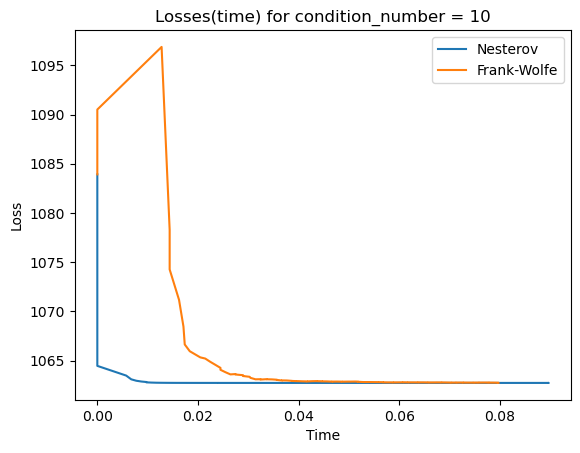

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1095.50it/s]


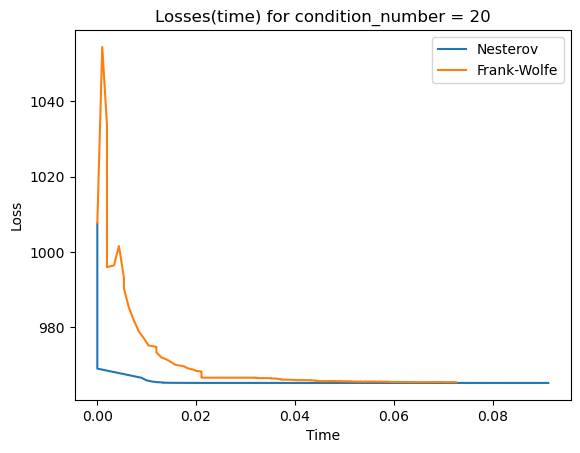

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1054.59it/s]


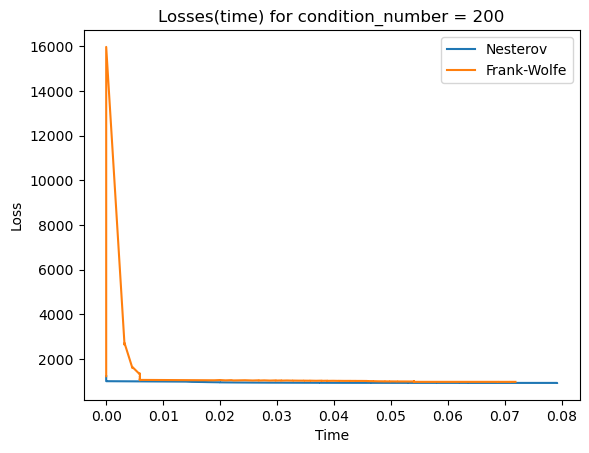

In [11]:
n_steps = 100
#ns = [50, 100, 200]
#ds = [50, 100, 200]
n = 1000
d = 100
cond_numbers = [10, 20, 200]

#for n, d, cond_number in zip(ns, ds, cond_numbers):
for cond_number in cond_numbers:
    A = construct_random_matrix(n, d, cond_number)
    b = np.abs(np.random.normal(size=n))
    x = np.random.normal(size=d)
    x = x / np.sum(np.abs(x))

    nesterov = Nesterov(A, b)
    xs_nesterov, losses_nesterov, times_nesterov = nesterov.run(x, n_steps)

    frank_wolfe = Frank_Wolfe(A, b)
    xs_wolfe, losses_wolfe, times_wolfe = frank_wolfe.run(x, n_steps)

    plt.title("Losses(time) for condition_number = {}".format(cond_number))
    plt.plot(times_nesterov, losses_nesterov, label="Nesterov")
    plt.plot(times_wolfe, losses_wolfe, label="Frank-Wolfe")
    plt.xlabel("Time")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


# Experiments for sparce matrices

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 164.13it/s]


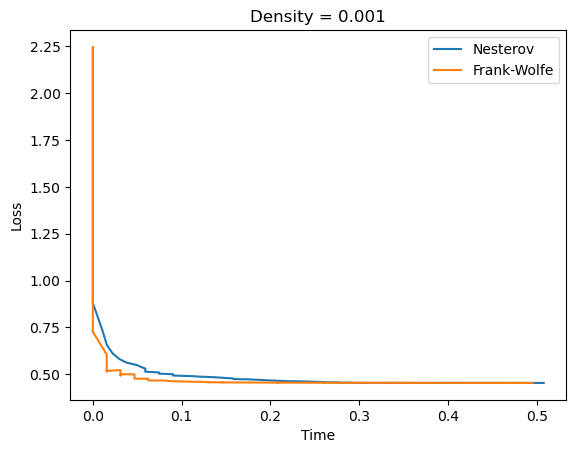

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 150.62it/s]


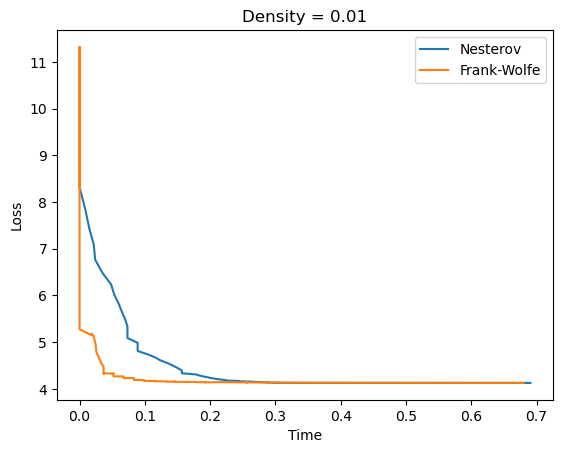

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 166.80it/s]


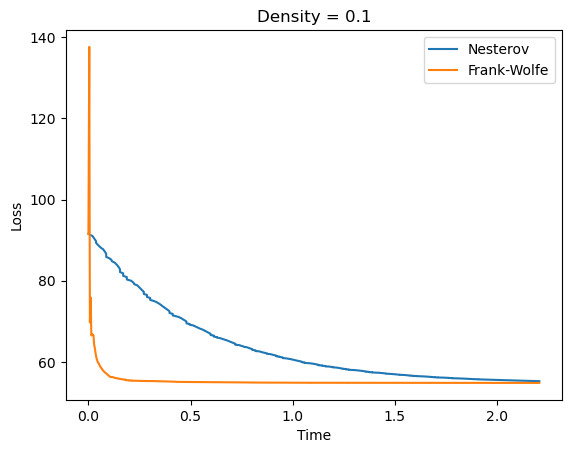

In [10]:
n = 2000
d = 2000

densities = [0.001, 0.01, 0.1, ]

for density in densities:
    A = random(n, d, density=density, format='csr', random_state=42)
    b = random(n, 1, density=density, format='csr', random_state=42)
    x = random(d, 1, density=0.001, format='csr', random_state=42)

    frank_wolfe = Frank_Wolfe(A, b)
    xs_wolfe, losses_wolfe, times_wolfe = frank_wolfe.run(x, n_steps=400)

    nesterov = Nesterov(A.toarray().astype(np.float64), b.toarray().astype(np.float64))
    mode = "sparce"
    if density > 0.09:
        mode = "dense"
    xs_nesterov, losses_nesterov, times_nesterov = nesterov.run(x.toarray(), n_steps=400, mode=mode)

    m = min(times_wolfe[-1], times_nesterov[-1])
    plt.plot(times_nesterov[np.argwhere(times_nesterov < m)], losses_nesterov[np.argwhere(times_nesterov < m)], label="Nesterov")
    plt.plot(times_wolfe[np.argwhere(times_wolfe < m)], losses_wolfe[np.argwhere(times_wolfe < m)], label="Frank-Wolfe")
    
    plt.title("Density = {}".format(density))
    plt.xlabel("Time")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()